### Brain MRI images for tumour segmentation task

**Dataset detail**

The dataset was obtained from a medical segmentation [decathlon](http://medicaldecathlon.com/). Each sample is composed of two files:

1. Image file: a 4D array in the shape of (240, 240, 155, 4). Each MRI is represented in 3D volume (155 layers of 240 x 240), while the final dimension (4) indicates a biological information. Also, each file is stored in the NifTI-1 format.

2. Label file: a 3D array in the shape of (240, 240, 155). Each value indicates the label (0 ~ 3) corresponding to: background, edema, non-enhancing tumour, and enhancing tumour.

For this small experiment, there are 71 brain MRI image files.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

In [4]:
import zipfile

source_dir = '/content/drive/MyDrive/Colab Notebooks/tumour_segmentation'
zip_ref = zipfile.ZipFile(source_dir + '/mri_images.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [6]:
import os
from pathlib import Path

base_dir = Path('/tmp/mri_images')
train_img_dir = base_dir / 'images'
train_lbs_dir = base_dir / 'labels'

train_img_fnames = os.listdir(train_img_dir)
train_lbs_fnames = os.listdir(train_lbs_dir)

print('total training image files: ', len(train_img_fnames))

total training image files:  71


In [7]:
import random
import nibabel # open neuro-image files

img_file = train_img_dir / 'BRATS_001.nii.gz'
img = nibabel.load(img_file)
img = img.get_fdata()

img.shape

(240, 240, 155, 4)

In [9]:
label_file = train_lbs_dir / 'BRATS_001.nii.gz'
label = nibabel.load(label_file)
label = label.get_fdata()

label.shape

(240, 240, 155)

In [14]:
import matplotlib.pyplot as plt
from ipywidgets import interact

def explore_layers(layer):
    plt.imshow(img[:, :, layer, 2], cmap='gray')
    plt.axis('off')

interact(explore_layers, layer=(0, img.shape[2] - 1))

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

<function __main__.explore_layers>

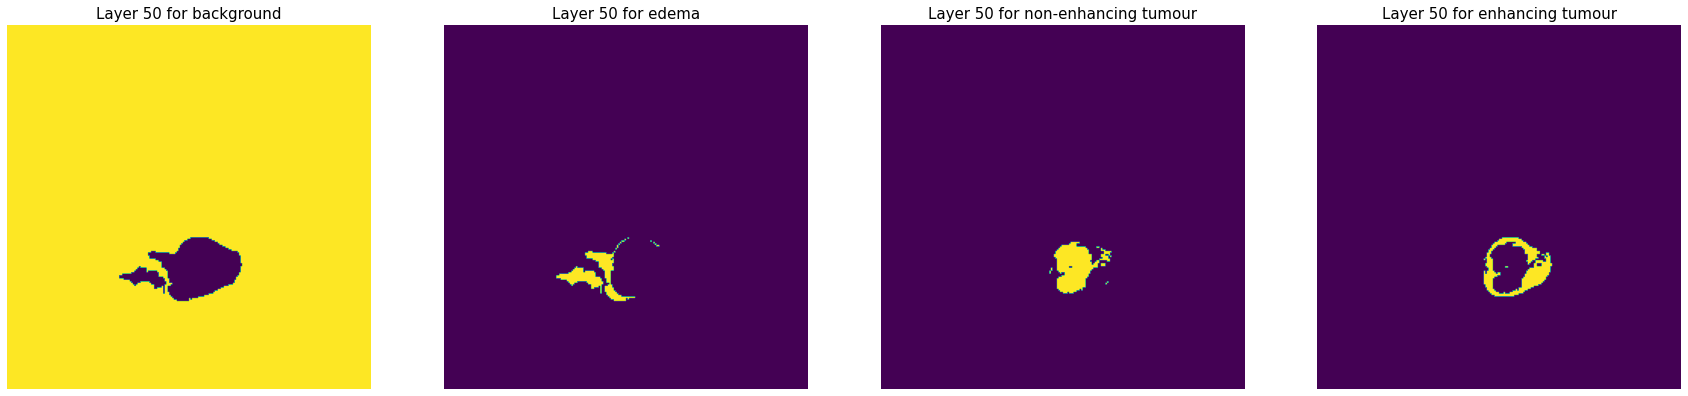

In [10]:
import numpy as np

condition_labels = ['background',
                    'edema',
                    'non-enhancing tumour',
                    'enhancing tumour']

layer = 50
nrows = 1
ncols = 4
f, sp = plt.subplots(nrows, ncols, figsize=(30, 20))
label = label[:, :, layer]

for i in range(ncols):
    mask = np.where(label == i, 255, 0)

    sp[i].imshow(mask)
    sp[i].set_title(f'Layer {layer} for {condition_labels[i]}', fontsize=15)
    sp[i].axis('off')

### 2. Model declaration

**U-Net**

Take a look at the original paper for more detail: [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf).

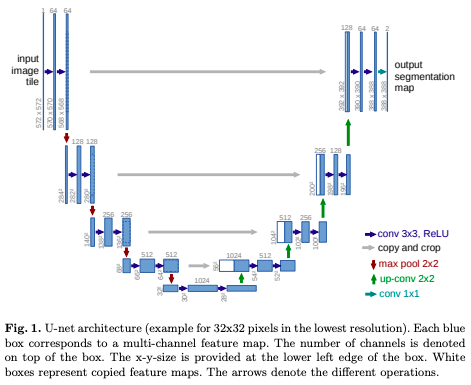

In [15]:
import tensorflow as tf

from tensorflow.keras import backend
backend.set_image_data_format('channels_first')

# input layer
input_layer = tf.keras.layers.Input(shape=(4, 160, 160, 16)) # (channels, h, w, layer)

In [16]:
# contraction (downward path)
#
# depth 0
down_convl_depth0_layer0 = tf.keras.layers.Conv3D(32,
                                                  kernel_size=(3, 3, 3),
                                                  strides=(1, 1, 1),
                                                  padding='same',                                                  
                                                  activation='relu')(input_layer)

down_convl_depth0_layer1 = tf.keras.layers.Conv3D(64,
                                                  kernel_size=(3, 3, 3),
                                                  strides=(1, 1, 1),
                                                  padding='same',
                                                  activation='relu')(down_convl_depth0_layer0)


down_mpool_depth0 = tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2))(down_convl_depth0_layer1)

# depth 1
down_convl_depth1_layer0 = tf.keras.layers.Conv3D(64,
                                                  kernel_size=(3, 3, 3),
                                                  strides=(1, 1, 1),
                                                  padding='same',
                                                  activation='relu')(down_mpool_depth0)

down_convl_depth1_layer1 = tf.keras.layers.Conv3D(128,
                                                  kernel_size=(3, 3, 3),
                                                  strides=(1, 1, 1),
                                                  padding='same',
                                                  activation='relu')(down_convl_depth1_layer0)

down_mpool_depth1 = tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2))(down_convl_depth1_layer1)

# depth 2
down_convl_depth2_layer0 = tf.keras.layers.Conv3D(128,
                                                  kernel_size=(3, 3, 3),
                                                  strides=(1, 1, 1),
                                                  padding='same',
                                                  activation='relu')(down_mpool_depth1)

down_convl_depth2_layer1 = tf.keras.layers.Conv3D(256,
                                                  kernel_size=(3, 3, 3),
                                                  strides=(1, 1, 1),
                                                  padding='same',
                                                  activation='relu')(down_convl_depth2_layer0)

down_mpool_depth2 = tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2))(down_convl_depth2_layer1)

# depth 3
down_convl_depth3_layer0 = tf.keras.layers.Conv3D(256,
                                                  kernel_size=(3, 3, 3),
                                                  strides=(1, 1, 1),
                                                  padding='same',
                                                  activation='relu')(down_mpool_depth2)

down_convl_depth3_layer1 = tf.keras.layers.Conv3D(512,
                                                  kernel_size=(3, 3, 3),
                                                  strides=(1, 1, 1),
                                                  padding='same',
                                                  activation='relu')(down_convl_depth3_layer0)

down_mpool_depth3 = tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2))(down_convl_depth3_layer1)

# depth 4
down_convl_depth4_layer0 = tf.keras.layers.Conv3D(512,
                                                  kernel_size=(3, 3, 3),
                                                  strides=(1, 1, 1),
                                                  padding='same',
                                                  activation='relu')(down_mpool_depth3)

down_convl_depth4_layer1 = tf.keras.layers.Conv3D(1024,
                                                  kernel_size=(3, 3, 3),
                                                  strides=(1, 1, 1),
                                                  padding='same',
                                                  activation='relu')(down_convl_depth4_layer0)

up_sampling_depth4 = tf.keras.layers.UpSampling3D(size=(2, 2, 2))(down_convl_depth4_layer1)

# expansion (upward path)
#
# depth 3
up_concat_depth3 = tf.keras.layers.concatenate([up_sampling_depth4, down_convl_depth3_layer1], axis=1)

up_convl_depth3_layer0 = tf.keras.layers.Conv3D(256,
                                                kernel_size=(3, 3, 3),
                                                strides=(1, 1, 1),
                                                padding='same',
                                                activation='relu')(up_concat_depth3)

up_convl_depth3_layer1 = tf.keras.layers.Conv3D(512,
                                                kernel_size=(3, 3, 3),
                                                strides=(1, 1, 1),
                                                padding='same',
                                                activation='relu')(up_convl_depth3_layer0)

up_sampling_depth3 = tf.keras.layers.UpSampling3D(size=(2, 2, 2))(up_convl_depth3_layer1)

# depth 2
up_concat_depth2 = tf.keras.layers.concatenate([up_sampling_depth3, down_convl_depth2_layer1], axis=1)

up_convl_depth2_layer0 = tf.keras.layers.Conv3D(128,
                                                kernel_size=(3, 3, 3),
                                                strides=(1, 1, 1),
                                                padding='same',
                                                activation='relu')(up_concat_depth2)

up_convl_depth2_layer1 = tf.keras.layers.Conv3D(256,
                                                kernel_size=(3, 3, 3),
                                                strides=(1, 1, 1),
                                                padding='same',
                                                activation='relu')(up_convl_depth2_layer0)

up_sampling_depth2 = tf.keras.layers.UpSampling3D(size=(2, 2, 2))(up_convl_depth2_layer1)

# depth 1
up_concat_depth1 = tf.keras.layers.concatenate([up_sampling_depth2, down_convl_depth1_layer1], axis=1)

up_convl_depth1_layer0 = tf.keras.layers.Conv3D(64,
                                                kernel_size=(3, 3, 3),
                                                strides=(1, 1, 1),
                                                padding='same',
                                                activation='relu')(up_concat_depth1)

up_convl_depth1_layer1 = tf.keras.layers.Conv3D(128,
                                                kernel_size=(3, 3, 3),
                                                strides=(1, 1, 1),
                                                padding='same',
                                                activation='relu')(up_convl_depth1_layer0)

up_sampling_depth1 = tf.keras.layers.UpSampling3D(size=(2, 2, 2))(up_convl_depth1_layer1)

# depth 1
up_concat_depth0 = tf.keras.layers.concatenate([up_sampling_depth1, down_convl_depth0_layer1], axis=1)

up_convl_depth0_layer0 = tf.keras.layers.Conv3D(32,
                                                kernel_size=(3, 3, 3),
                                                strides=(1, 1, 1),
                                                padding='same',
                                                activation='relu')(up_concat_depth0)

up_convl_depth0_layer1 = tf.keras.layers.Conv3D(64,
                                                kernel_size=(3, 3, 3),
                                                strides=(1, 1, 1),
                                                padding='same',
                                                activation='relu')(up_convl_depth0_layer0)

# output layer
final_conv = tf.keras.layers.Conv3D(3,
                                    kernel_size=(1, 1, 1),
                                    strides=(1, 1, 1),
                                    padding='valid',
                                    activation='sigmoid')(up_convl_depth0_layer1)

# final model
u_net_model = tf.keras.models.Model(inputs=input_layer, outputs=final_conv)
print(u_net_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 160, 160, 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 32, 160, 160, 3488        input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 64, 160, 160, 55360       conv3d[0][0]                     
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 64, 80, 80, 8 0           conv3d_1[0][0]                   
______________________________________________________________________________________________

**Soft Dice Loss**

The U-Net model outputs *probabilities* that each voxel is positive (i.e., edema) or not. The soft dice coefficient loss function takes real input, instead of discrete numbers, which measures how well two images (here, the model's prediction and ground truth) overlap. Note that we shouldn't use categorical crossentropy to measure loss because there is significant imbalance between classes (mostly background).

The formula is: 

$$\mathcal{L}_{Dice}(p, q) = 1 - \frac{1}{N} \sum_{c=1}^{C} \frac{2\times\sum_{i, j} p_{cij}q_{cij} + \epsilon}{\left(\sum_{i, j} p_{cij}^2 \right) + \left(\sum_{i, j} q_{cij}^2 \right) + \epsilon}$$

In [17]:
from keras.backend import sum, mean

def soft_dice_loss(y_pred, y_true, axis=(1, 2, 3), eps=0.00001):
    num = sum(y_pred * y_true, axis)
    den = sum(y_pred**2, axis) + sum(y_true**2, axis)
    coeff = 1 - mean((2 * num + eps) / (den + eps))

    return coeff

### 3. Training and evaluation


In [18]:
from tensorflow.keras.optimizers import RMSprop

u_net_model.compile(loss=soft_dice_loss,
                    metrics=[soft_dice_loss],
                    optimizer=RMSprop(0.0001))

In [ ]:
# TODO: sub-volume sampling for training